In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt
import tempfile
import os
%load_ext tensorboard

Using TensorFlow backend.


In [2]:
# Reproducibility
seed = 9 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [3]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [4]:
### RECEIVE 10,000 PIECES OF DATA ###

N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
# X_scale, X_test, Y_scale, Y_test = train_test_split(X_scale, Y_scale, test_size=0.15)

In [5]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
#     hp_regularizer = hp.Choice('regularizer_penalty', values=[1e-4, 1e-5, 1e-6])
#     for i in range(hp.Int('n_layers', 1, 2)):
    model.add(keras.layers.Dense(hp.Int(f'hidden_units', min_value=20, max_value=200, step=2), kernel_regularizer=tf.keras.regularizers.l2(1e-6)))
#     model.add(keras.layers.Dense(hp.Int('hidden_units', min_value=10, max_value=320, step=1), kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
#         model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1)))
#     SHOULD DROPOUT BE INCLUDED??
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-6)))
#     model.add(keras.layers.Dense(N_channels, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [6]:
### CREATE HYPERBAND TUNER ###

# The maximum number of epochs to train one model. It is recommended to 
# set this to a value slightly higher than the expected time 
# to convergence for your largest Model, and to use early stopping 
# during training
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_mean_squared_error', 'min'),
                     max_epochs=50,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers_fpga',
                     overwrite=True,
                     seed=8)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5)

In [7]:
### SEARCHING FOR THE ANN LAYOUT THAT ACCOMPLISHES THE HYPERPARAMTER GOALS ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.2, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1483 - mean_squared_error: 0.1482 - mean_absolute_error: 0.3504 - val_loss: 0.0851 - val_mean_squared_error: 0.0849 - val_mean_absolute_error: 0.2596
Epoch 2/2
8000/8000 - 1s - loss: 0.0592 - mean_squared_error: 0.0590 - mean_absolute_error: 0.2048 - val_loss: 0.0345 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1562


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1170 - mean_squared_error: 0.1168 - mean_absolute_error: 0.3055 - val_loss: 0.0457 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1870
Epoch 2/2
8000/8000 - 1s - loss: 0.0253 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1333 - val_loss: 0.0103 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0878


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1221 - mean_squared_error: 0.1219 - mean_absolute_error: 0.3130 - val_loss: 0.0528 - val_mean_squared_error: 0.0526 - val_mean_absolute_error: 0.2002
Epoch 2/2
8000/8000 - 1s - loss: 0.0303 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1455 - val_loss: 0.0126 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0976


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0477 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1509 - val_loss: 0.0052 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0481
Epoch 2/2
8000/8000 - 1s - loss: 0.0111 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0585 - val_loss: 0.0051 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0393


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2161 - mean_squared_error: 0.2160 - mean_absolute_error: 0.4328 - val_loss: 0.1996 - val_mean_squared_error: 0.1995 - val_mean_absolute_error: 0.4165
Epoch 2/2
8000/8000 - 1s - loss: 0.1918 - mean_squared_error: 0.1917 - mean_absolute_error: 0.4064 - val_loss: 0.1804 - val_mean_squared_error: 0.1803 - val_mean_absolute_error: 0.3944


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2194 - mean_squared_error: 0.2193 - mean_absolute_error: 0.4411 - val_loss: 0.2038 - val_mean_squared_error: 0.2037 - val_mean_absolute_error: 0.4248
Epoch 2/2
8000/8000 - 1s - loss: 0.1972 - mean_squared_error: 0.1972 - mean_absolute_error: 0.4140 - val_loss: 0.1883 - val_mean_squared_error: 0.1882 - val_mean_absolute_error: 0.4034


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0165 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0716 - val_loss: 0.0017 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0234
Epoch 2/2
8000/8000 - 1s - loss: 0.0037 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0326 - val_loss: 0.0022 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0242


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0965 - mean_squared_error: 0.0963 - mean_absolute_error: 0.2723 - val_loss: 0.0264 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1429
Epoch 2/2
8000/8000 - 1s - loss: 0.0140 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0995 - val_loss: 0.0059 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0660


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1090 - mean_squared_error: 0.1088 - mean_absolute_error: 0.2930 - val_loss: 0.0379 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1701
Epoch 2/2
8000/8000 - 1s - loss: 0.0204 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1196 - val_loss: 0.0081 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0782


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2049 - mean_squared_error: 0.2048 - mean_absolute_error: 0.4253 - val_loss: 0.1869 - val_mean_squared_error: 0.1868 - val_mean_absolute_error: 0.4037
Epoch 2/2
8000/8000 - 1s - loss: 0.1748 - mean_squared_error: 0.1747 - mean_absolute_error: 0.3896 - val_loss: 0.1596 - val_mean_squared_error: 0.1595 - val_mean_absolute_error: 0.3718


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2237 - mean_squared_error: 0.2236 - mean_absolute_error: 0.4391 - val_loss: 0.2093 - val_mean_squared_error: 0.2092 - val_mean_absolute_error: 0.4269
Epoch 2/2
8000/8000 - 0s - loss: 0.2043 - mean_squared_error: 0.2042 - mean_absolute_error: 0.4194 - val_loss: 0.1952 - val_mean_squared_error: 0.1952 - val_mean_absolute_error: 0.4104


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0210 - mean_squared_error: 0.0205 - mean_absolute_error: 0.0859 - val_loss: 0.0023 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0282
Epoch 2/2
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0371 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0301


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.2217 - mean_squared_error: 0.2216 - mean_absolute_error: 0.4423 - val_loss: 0.2103 - val_mean_squared_error: 0.2102 - val_mean_absolute_error: 0.4325
Epoch 2/2
8000/8000 - 1s - loss: 0.2052 - mean_squared_error: 0.2051 - mean_absolute_error: 0.4247 - val_loss: 0.1972 - val_mean_squared_error: 0.1972 - val_mean_absolute_error: 0.4160


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2087 - mean_squared_error: 0.2086 - mean_absolute_error: 0.4302 - val_loss: 0.1906 - val_mean_squared_error: 0.1905 - val_mean_absolute_error: 0.4075
Epoch 2/2
8000/8000 - 1s - loss: 0.1821 - mean_squared_error: 0.1820 - mean_absolute_error: 0.3966 - val_loss: 0.1681 - val_mean_squared_error: 0.1680 - val_mean_absolute_error: 0.3809


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2207 - mean_squared_error: 0.2206 - mean_absolute_error: 0.4378 - val_loss: 0.2038 - val_mean_squared_error: 0.2036 - val_mean_absolute_error: 0.4197
Epoch 2/2
8000/8000 - 1s - loss: 0.1962 - mean_squared_error: 0.1961 - mean_absolute_error: 0.4101 - val_loss: 0.1849 - val_mean_squared_error: 0.1848 - val_mean_absolute_error: 0.3983


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0188 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0793 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0265
Epoch 2/2
8000/8000 - 1s - loss: 0.0042 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0353 - val_loss: 0.0022 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0244


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1242 - mean_squared_error: 0.1241 - mean_absolute_error: 0.3163 - val_loss: 0.0533 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.2024
Epoch 2/2
8000/8000 - 1s - loss: 0.0306 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1465 - val_loss: 0.0127 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0979


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1288 - mean_squared_error: 0.1287 - mean_absolute_error: 0.3242 - val_loss: 0.0597 - val_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.2147
Epoch 2/2
8000/8000 - 1s - loss: 0.0357 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1584 - val_loss: 0.0156 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1076


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1002 - mean_squared_error: 0.1000 - mean_absolute_error: 0.2789 - val_loss: 0.0294 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1502
Epoch 2/2
8000/8000 - 1s - loss: 0.0156 - mean_squared_error: 0.0152 - mean_absolute_error: 0.1047 - val_loss: 0.0064 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0688


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0221 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0890 - val_loss: 0.0020 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0267
Epoch 2/2
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0372 - val_loss: 0.0026 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0273


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2024 - mean_squared_error: 0.2023 - mean_absolute_error: 0.4236 - val_loss: 0.1828 - val_mean_squared_error: 0.1827 - val_mean_absolute_error: 0.4001
Epoch 2/2
8000/8000 - 1s - loss: 0.1685 - mean_squared_error: 0.1684 - mean_absolute_error: 0.3833 - val_loss: 0.1519 - val_mean_squared_error: 0.1518 - val_mean_absolute_error: 0.3637


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0160 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0703 - val_loss: 0.0017 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0233
Epoch 2/2
8000/8000 - 1s - loss: 0.0037 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0323 - val_loss: 0.0029 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0277


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0203 - mean_squared_error: 0.0198 - mean_absolute_error: 0.0839 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0268
Epoch 2/2
8000/8000 - 1s - loss: 0.0043 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0358 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0244


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1423 - mean_squared_error: 0.1422 - mean_absolute_error: 0.3420 - val_loss: 0.0753 - val_mean_squared_error: 0.0752 - val_mean_absolute_error: 0.2424
Epoch 2/2
8000/8000 - 1s - loss: 0.0487 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1852 - val_loss: 0.0250 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1344


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0995 - mean_squared_error: 0.0993 - mean_absolute_error: 0.2771 - val_loss: 0.0280 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1466
Epoch 2/2
8000/8000 - 1s - loss: 0.0147 - mean_squared_error: 0.0144 - mean_absolute_error: 0.1017 - val_loss: 0.0061 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0671


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.0631 - mean_squared_error: 0.0628 - mean_absolute_error: 0.1806 - val_loss: 0.0189 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0854
Epoch 2/2
8000/8000 - 1s - loss: 0.0285 - mean_squared_error: 0.0280 - mean_absolute_error: 0.0944 - val_loss: 0.0173 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0733


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0999 - mean_squared_error: 0.0997 - mean_absolute_error: 0.2783 - val_loss: 0.0292 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1503
Epoch 2/2
8000/8000 - 1s - loss: 0.0153 - mean_squared_error: 0.0150 - mean_absolute_error: 0.1037 - val_loss: 0.0063 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0684


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1745 - mean_squared_error: 0.1744 - mean_absolute_error: 0.3856 - val_loss: 0.1219 - val_mean_squared_error: 0.1218 - val_mean_absolute_error: 0.3192
Epoch 2/2
8000/8000 - 1s - loss: 0.0963 - mean_squared_error: 0.0961 - mean_absolute_error: 0.2674 - val_loss: 0.0747 - val_mean_squared_error: 0.0746 - val_mean_absolute_error: 0.2278


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.1030 - mean_squared_error: 0.1028 - mean_absolute_error: 0.2829 - val_loss: 0.0314 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1558
Epoch 2/2
8000/8000 - 1s - loss: 0.0166 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1083 - val_loss: 0.0068 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0712


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1343 - mean_squared_error: 0.1341 - mean_absolute_error: 0.3308 - val_loss: 0.0649 - val_mean_squared_error: 0.0647 - val_mean_absolute_error: 0.2244
Epoch 2/2
8000/8000 - 1s - loss: 0.0400 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1679 - val_loss: 0.0182 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1160


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0173 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0746 - val_loss: 0.0019 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0246
Epoch 2/2
8000/8000 - 1s - loss: 0.0038 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0334 - val_loss: 0.0023 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0254


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.2154 - mean_squared_error: 0.2153 - mean_absolute_error: 0.4329 - val_loss: 0.2009 - val_mean_squared_error: 0.2008 - val_mean_absolute_error: 0.4177
Epoch 2/2
8000/8000 - 1s - loss: 0.1935 - mean_squared_error: 0.1934 - mean_absolute_error: 0.4078 - val_loss: 0.1835 - val_mean_squared_error: 0.1834 - val_mean_absolute_error: 0.3969


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 1s - loss: 0.1605 - mean_squared_error: 0.1604 - mean_absolute_error: 0.3671 - val_loss: 0.1020 - val_mean_squared_error: 0.1019 - val_mean_absolute_error: 0.2877
Epoch 2/2
8000/8000 - 1s - loss: 0.0772 - mean_squared_error: 0.0770 - mean_absolute_error: 0.2361 - val_loss: 0.0531 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1918


Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 - 2s - loss: 0.0180 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0771 - val_loss: 0.0019 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0250
Epoch 2/2
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0345 - val_loss: 0.0025 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0258


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0169 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0726 - val_loss: 0.0019 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0244
Epoch 4/6
8000/8000 - 1s - loss: 0.0037 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0325 - val_loss: 0.0024 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0253
Epoch 5/6
8000/8000 - 1s - loss: 0.0041 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0328 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0280
Epoch 6/6
8000/8000 - 1s - loss: 0.0042 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0329 - val_loss: 0.0036 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0302


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0163 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0711 - val_loss: 0.0018 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0238
Epoch 4/6
8000/8000 - 1s - loss: 0.0036 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0021 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0237
Epoch 5/6
8000/8000 - 1s - loss: 0.0038 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0319 - val_loss: 0.0032 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0283
Epoch 6/6
8000/8000 - 1s - loss: 0.0043 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0331 - val_loss: 0.0028 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0257


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0179 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0768 - val_loss: 0.0023 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0270
Epoch 4/6
8000/8000 - 1s - loss: 0.0039 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0339 - val_loss: 0.0022 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0240
Epoch 5/6
8000/8000 - 1s - loss: 0.0042 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0338 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0288
Epoch 6/6
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0345 - val_loss: 0.0028 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0262


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0179 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0757 - val_loss: 0.0023 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0271
Epoch 4/6
8000/8000 - 1s - loss: 0.0038 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0334 - val_loss: 0.0024 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0255
Epoch 5/6
8000/8000 - 1s - loss: 0.0043 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0337 - val_loss: 0.0030 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0274
Epoch 6/6
8000/8000 - 1s - loss: 0.0043 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0336 - val_loss: 0.0024 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0244


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0222 - mean_squared_error: 0.0218 - mean_absolute_error: 0.0894 - val_loss: 0.0024 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0292
Epoch 4/6
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0375 - val_loss: 0.0026 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0270
Epoch 5/6
8000/8000 - 1s - loss: 0.0048 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0364 - val_loss: 0.0028 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0267
Epoch 6/6
8000/8000 - 1s - loss: 0.0052 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0373 - val_loss: 0.0039 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0309


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0206 - mean_squared_error: 0.0201 - mean_absolute_error: 0.0848 - val_loss: 0.0022 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0274
Epoch 4/6
8000/8000 - 1s - loss: 0.0043 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0361 - val_loss: 0.0022 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0246
Epoch 5/6
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0353 - val_loss: 0.0035 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0305
Epoch 6/6
8000/8000 - 1s - loss: 0.0048 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0360 - val_loss: 0.0029 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0264


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0189 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0799 - val_loss: 0.0023 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0272
Epoch 4/6
8000/8000 - 1s - loss: 0.0042 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0354 - val_loss: 0.0027 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0270
Epoch 5/6
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0349 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0282
Epoch 6/6
8000/8000 - 1s - loss: 0.0047 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0352 - val_loss: 0.0032 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0279


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0214 - mean_squared_error: 0.0209 - mean_absolute_error: 0.0871 - val_loss: 0.0024 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0287
Epoch 4/6
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0363 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0243
Epoch 5/6
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0355 - val_loss: 0.0030 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0281
Epoch 6/6
8000/8000 - 1s - loss: 0.0050 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0363 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0282


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 1s - loss: 0.0494 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1548 - val_loss: 0.0052 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0482
Epoch 4/6
8000/8000 - 1s - loss: 0.0110 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0588 - val_loss: 0.0051 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0398
Epoch 5/6
8000/8000 - 0s - loss: 0.0103 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0527 - val_loss: 0.0049 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0366
Epoch 6/6
8000/8000 - 0s - loss: 0.0101 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0514 - val_loss: 0.0054 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0379


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0981 - mean_squared_error: 0.0980 - mean_absolute_error: 0.2746 - val_loss: 0.0268 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1435
Epoch 4/6
8000/8000 - 1s - loss: 0.0142 - mean_squared_error: 0.0139 - mean_absolute_error: 0.1002 - val_loss: 0.0060 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0665
Epoch 5/6
8000/8000 - 1s - loss: 0.0056 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0598 - val_loss: 0.0032 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0449
Epoch 6/6
8000/8000 - 1s - loss: 0.0039 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0458 - val_loss: 0.0024 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0354


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0958 - mean_squared_error: 0.0956 - mean_absolute_error: 0.2711 - val_loss: 0.0261 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1418
Epoch 4/6
8000/8000 - 1s - loss: 0.0139 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0990 - val_loss: 0.0058 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0655
Epoch 5/6
8000/8000 - 1s - loss: 0.0055 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0592 - val_loss: 0.0031 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0441
Epoch 6/6
8000/8000 - 1s - loss: 0.0039 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0454 - val_loss: 0.0024 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0354


Train on 8000 samples, validate on 2000 samples
Epoch 3/6
8000/8000 - 2s - loss: 0.0987 - mean_squared_error: 0.0985 - mean_absolute_error: 0.2762 - val_loss: 0.0284 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1484
Epoch 4/6
8000/8000 - 1s - loss: 0.0151 - mean_squared_error: 0.0147 - mean_absolute_error: 0.1032 - val_loss: 0.0063 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0683
Epoch 5/6
8000/8000 - 1s - loss: 0.0058 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0610 - val_loss: 0.0032 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0455
Epoch 6/6
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0467 - val_loss: 0.0026 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0366


Train on 8000 samples, validate on 2000 samples
Epoch 7/17
8000/8000 - 2s - loss: 0.0160 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0703 - val_loss: 0.0019 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0238
Epoch 8/17
8000/8000 - 1s - loss: 0.0036 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0322 - val_loss: 0.0024 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0249
Epoch 9/17
8000/8000 - 1s - loss: 0.0039 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0321 - val_loss: 0.0030 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0278
Epoch 10/17
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0334 - val_loss: 0.0028 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0255
Epoch 11/17
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0335 - val_loss: 0.0036 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0298
Epoch 12/17
8000/800

Train on 8000 samples, validate on 2000 samples
Epoch 7/17
8000/8000 - 2s - loss: 0.0165 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0717 - val_loss: 0.0020 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0251
Epoch 8/17
8000/8000 - 1s - loss: 0.0036 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0324 - val_loss: 0.0024 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0252
Epoch 9/17
8000/8000 - 1s - loss: 0.0041 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0329 - val_loss: 0.0033 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0291
Epoch 10/17
8000/8000 - 1s - loss: 0.0043 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0334 - val_loss: 0.0033 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0286
Epoch 11/17
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0337 - val_loss: 0.0035 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0295
Epoch 12/17
8000/800

Train on 8000 samples, validate on 2000 samples
Epoch 7/17
8000/8000 - 2s - loss: 0.0218 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0879 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0270
Epoch 8/17
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0367 - val_loss: 0.0029 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0284
Epoch 9/17
8000/8000 - 1s - loss: 0.0048 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0361 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0285
Epoch 10/17
8000/8000 - 1s - loss: 0.0048 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0358 - val_loss: 0.0035 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0298
Epoch 11/17
8000/8000 - 1s - loss: 0.0050 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0360 - val_loss: 0.0029 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0266
Epoch 12/17
8000/800

Train on 8000 samples, validate on 2000 samples
Epoch 7/17
8000/8000 - 2s - loss: 0.0179 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0762 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0260
Epoch 8/17
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0342 - val_loss: 0.0037 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0319
Epoch 9/17
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0342 - val_loss: 0.0033 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0289
Epoch 10/17
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0346 - val_loss: 0.0030 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0269
Epoch 11/17
8000/8000 - 1s - loss: 0.0047 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0346 - val_loss: 0.0034 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0290
Epoch 12/17
8000/800

Train on 8000 samples, validate on 2000 samples
Epoch 18/50
8000/8000 - 2s - loss: 0.0159 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0699 - val_loss: 0.0020 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0248
Epoch 19/50
8000/8000 - 1s - loss: 0.0037 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0326 - val_loss: 0.0023 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0249
Epoch 20/50
8000/8000 - 1s - loss: 0.0039 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0320 - val_loss: 0.0035 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0296
Epoch 21/50
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0336 - val_loss: 0.0031 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0270
Epoch 22/50
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0336 - val_loss: 0.0035 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0290
Epoch 23/50
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 18/50
8000/8000 - 2s - loss: 0.0171 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0734 - val_loss: 0.0019 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0244
Epoch 19/50
8000/8000 - 1s - loss: 0.0038 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0329 - val_loss: 0.0027 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0269
Epoch 20/50
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0325 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0285
Epoch 21/50
8000/8000 - 1s - loss: 0.0043 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0334 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0276
Epoch 22/50
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0338 - val_loss: 0.0034 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0283
Epoch 23/50
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.0175 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0750 - val_loss: 0.0020 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0254
Epoch 2/6
8000/8000 - 1s - loss: 0.0039 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0337 - val_loss: 0.0025 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0260
Epoch 3/6
8000/8000 - 1s - loss: 0.0042 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0334 - val_loss: 0.0029 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0271
Epoch 4/6
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0340 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0283
Epoch 5/6
8000/8000 - 1s - loss: 0.0047 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0345 - val_loss: 0.0034 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0289
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.0241 - mean_squared_error: 0.0237 - mean_absolute_error: 0.0952 - val_loss: 0.0024 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0295
Epoch 2/6
8000/8000 - 1s - loss: 0.0051 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0399 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0293
Epoch 3/6
8000/8000 - 1s - loss: 0.0054 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0385 - val_loss: 0.0042 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0337
Epoch 4/6
8000/8000 - 1s - loss: 0.0055 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0383 - val_loss: 0.0039 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0319
Epoch 5/6
8000/8000 - 1s - loss: 0.0057 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0386 - val_loss: 0.0039 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0317
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.0342 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1212 - val_loss: 0.0031 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0353
Epoch 2/6
8000/8000 - 1s - loss: 0.0075 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0483 - val_loss: 0.0039 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0337
Epoch 3/6
8000/8000 - 1s - loss: 0.0077 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0458 - val_loss: 0.0050 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0368
Epoch 4/6
8000/8000 - 1s - loss: 0.0077 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0449 - val_loss: 0.0051 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0367
Epoch 5/6
8000/8000 - 1s - loss: 0.0078 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0450 - val_loss: 0.0040 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0309
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 1s - loss: 0.1284 - mean_squared_error: 0.1282 - mean_absolute_error: 0.3221 - val_loss: 0.0577 - val_mean_squared_error: 0.0575 - val_mean_absolute_error: 0.2124
Epoch 2/6
8000/8000 - 1s - loss: 0.0344 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1553 - val_loss: 0.0146 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.1050
Epoch 3/6
8000/8000 - 1s - loss: 0.0121 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0893 - val_loss: 0.0056 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0641
Epoch 4/6
8000/8000 - 1s - loss: 0.0071 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0647 - val_loss: 0.0037 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0481
Epoch 5/6
8000/8000 - 1s - loss: 0.0056 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0534 - val_loss: 0.0027 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0388
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.2094 - mean_squared_error: 0.2093 - mean_absolute_error: 0.4313 - val_loss: 0.1915 - val_mean_squared_error: 0.1914 - val_mean_absolute_error: 0.4092
Epoch 2/6
8000/8000 - 1s - loss: 0.1811 - mean_squared_error: 0.1810 - mean_absolute_error: 0.3963 - val_loss: 0.1682 - val_mean_squared_error: 0.1681 - val_mean_absolute_error: 0.3815
Epoch 3/6
8000/8000 - 1s - loss: 0.1580 - mean_squared_error: 0.1578 - mean_absolute_error: 0.3695 - val_loss: 0.1451 - val_mean_squared_error: 0.1449 - val_mean_absolute_error: 0.3546
Epoch 4/6
8000/8000 - 1s - loss: 0.1349 - mean_squared_error: 0.1348 - mean_absolute_error: 0.3409 - val_loss: 0.1228 - val_mean_squared_error: 0.1227 - val_mean_absolute_error: 0.3255
Epoch 5/6
8000/8000 - 1s - loss: 0.1138 - mean_squared_error: 0.1137 - mean_absolute_error: 0.3117 - val_loss: 0.1031 - val_mean_squared_error: 0.1029 - val_mean_absolute_error: 0.2960
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.0268 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1022 - val_loss: 0.0023 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0298
Epoch 2/6
8000/8000 - 1s - loss: 0.0053 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0407 - val_loss: 0.0035 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0318
Epoch 3/6
8000/8000 - 1s - loss: 0.0054 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0387 - val_loss: 0.0034 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0302
Epoch 4/6
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0396 - val_loss: 0.0035 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0300
Epoch 5/6
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0393 - val_loss: 0.0041 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0321
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 1s - loss: 0.1325 - mean_squared_error: 0.1323 - mean_absolute_error: 0.3287 - val_loss: 0.0641 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.2238
Epoch 2/6
8000/8000 - 1s - loss: 0.0394 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1666 - val_loss: 0.0178 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1149
Epoch 3/6
8000/8000 - 1s - loss: 0.0144 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0970 - val_loss: 0.0064 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0691
Epoch 4/6
8000/8000 - 1s - loss: 0.0082 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0697 - val_loss: 0.0041 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0513
Epoch 5/6
8000/8000 - 1s - loss: 0.0063 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0572 - val_loss: 0.0029 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0411
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 1s - loss: 0.2263 - mean_squared_error: 0.2262 - mean_absolute_error: 0.4472 - val_loss: 0.2090 - val_mean_squared_error: 0.2089 - val_mean_absolute_error: 0.4303
Epoch 2/6
8000/8000 - 1s - loss: 0.2021 - mean_squared_error: 0.2020 - mean_absolute_error: 0.4198 - val_loss: 0.1931 - val_mean_squared_error: 0.1930 - val_mean_absolute_error: 0.4089
Epoch 3/6
8000/8000 - 1s - loss: 0.1878 - mean_squared_error: 0.1877 - mean_absolute_error: 0.4018 - val_loss: 0.1797 - val_mean_squared_error: 0.1797 - val_mean_absolute_error: 0.3938
Epoch 4/6
8000/8000 - 1s - loss: 0.1745 - mean_squared_error: 0.1744 - mean_absolute_error: 0.3869 - val_loss: 0.1665 - val_mean_squared_error: 0.1664 - val_mean_absolute_error: 0.3783
Epoch 5/6
8000/8000 - 1s - loss: 0.1611 - mean_squared_error: 0.1610 - mean_absolute_error: 0.3713 - val_loss: 0.1532 - val_mean_squared_error: 0.1531 - val_mean_absolute_error: 0.3621
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.2032 - mean_squared_error: 0.2030 - mean_absolute_error: 0.4244 - val_loss: 0.1835 - val_mean_squared_error: 0.1834 - val_mean_absolute_error: 0.4008
Epoch 2/6
8000/8000 - 1s - loss: 0.1700 - mean_squared_error: 0.1699 - mean_absolute_error: 0.3847 - val_loss: 0.1532 - val_mean_squared_error: 0.1530 - val_mean_absolute_error: 0.3651
Epoch 3/6
8000/8000 - 1s - loss: 0.1397 - mean_squared_error: 0.1395 - mean_absolute_error: 0.3485 - val_loss: 0.1234 - val_mean_squared_error: 0.1233 - val_mean_absolute_error: 0.3278
Epoch 4/6
8000/8000 - 1s - loss: 0.1113 - mean_squared_error: 0.1112 - mean_absolute_error: 0.3100 - val_loss: 0.0972 - val_mean_squared_error: 0.0970 - val_mean_absolute_error: 0.2903
Epoch 5/6
8000/8000 - 1s - loss: 0.0879 - mean_squared_error: 0.0877 - mean_absolute_error: 0.2730 - val_loss: 0.0767 - val_mean_squared_error: 0.0766 - val_mean_absolute_error: 0.2540
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.0185 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0784 - val_loss: 0.0020 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0259
Epoch 2/6
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0343 - val_loss: 0.0028 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0279
Epoch 3/6
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0343 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0288
Epoch 4/6
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0346 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0281
Epoch 5/6
8000/8000 - 1s - loss: 0.0047 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0348 - val_loss: 0.0031 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0274
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 1s - loss: 0.1590 - mean_squared_error: 0.1589 - mean_absolute_error: 0.3656 - val_loss: 0.1037 - val_mean_squared_error: 0.1036 - val_mean_absolute_error: 0.2893
Epoch 2/6
8000/8000 - 1s - loss: 0.0779 - mean_squared_error: 0.0777 - mean_absolute_error: 0.2372 - val_loss: 0.0533 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1924
Epoch 3/6
8000/8000 - 1s - loss: 0.0432 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1654 - val_loss: 0.0257 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1302
Epoch 4/6
8000/8000 - 1s - loss: 0.0251 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1198 - val_loss: 0.0127 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0906
Epoch 5/6
8000/8000 - 1s - loss: 0.0166 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0931 - val_loss: 0.0069 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0674
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.0162 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0710 - val_loss: 0.0024 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0274
Epoch 2/6
8000/8000 - 1s - loss: 0.0036 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0020 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0231
Epoch 3/6
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0328 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0287
Epoch 4/6
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0336 - val_loss: 0.0034 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0292
Epoch 5/6
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0334 - val_loss: 0.0033 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0283
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.0225 - mean_squared_error: 0.0220 - mean_absolute_error: 0.0903 - val_loss: 0.0027 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0305
Epoch 2/6
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0376 - val_loss: 0.0029 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0289
Epoch 3/6
8000/8000 - 1s - loss: 0.0050 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0369 - val_loss: 0.0030 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0279
Epoch 4/6
8000/8000 - 1s - loss: 0.0053 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0375 - val_loss: 0.0040 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0321
Epoch 5/6
8000/8000 - 1s - loss: 0.0052 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0370 - val_loss: 0.0037 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0303
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.1465 - mean_squared_error: 0.1464 - mean_absolute_error: 0.3493 - val_loss: 0.0817 - val_mean_squared_error: 0.0816 - val_mean_absolute_error: 0.2557
Epoch 2/6
8000/8000 - 1s - loss: 0.0552 - mean_squared_error: 0.0550 - mean_absolute_error: 0.1990 - val_loss: 0.0301 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1464
Epoch 3/6
8000/8000 - 1s - loss: 0.0231 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1224 - val_loss: 0.0106 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0884
Epoch 4/6
8000/8000 - 1s - loss: 0.0121 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0851 - val_loss: 0.0054 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0616
Epoch 5/6
8000/8000 - 1s - loss: 0.0087 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0678 - val_loss: 0.0035 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0479
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 - 2s - loss: 0.0168 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0730 - val_loss: 0.0025 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0279
Epoch 2/6
8000/8000 - 1s - loss: 0.0039 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0334 - val_loss: 0.0028 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0273
Epoch 3/6
8000/8000 - 1s - loss: 0.0041 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0330 - val_loss: 0.0028 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0267
Epoch 4/6
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0341 - val_loss: 0.0029 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0263
Epoch 5/6
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0339 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0274
Epoch 6/6
8000/8000 - 1s - 

Train on 8000 samples, validate on 2000 samples
Epoch 7/17
8000/8000 - 2s - loss: 0.0161 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0703 - val_loss: 0.0019 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0240
Epoch 8/17
8000/8000 - 1s - loss: 0.0038 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0329 - val_loss: 0.0033 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0295
Epoch 9/17
8000/8000 - 1s - loss: 0.0041 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0326 - val_loss: 0.0030 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0274
Epoch 10/17
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0337 - val_loss: 0.0039 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0311
Epoch 11/17
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0335 - val_loss: 0.0035 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0293
Epoch 12/17
8000/800

Train on 8000 samples, validate on 2000 samples
Epoch 7/17
8000/8000 - 2s - loss: 0.0176 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0753 - val_loss: 0.0022 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0265
Epoch 8/17
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0339 - val_loss: 0.0027 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0269
Epoch 9/17
8000/8000 - 1s - loss: 0.0041 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0332 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0288
Epoch 10/17
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0339 - val_loss: 0.0030 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0271
Epoch 11/17
8000/8000 - 1s - loss: 0.0048 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0351 - val_loss: 0.0036 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0300
Epoch 12/17
8000/800

Train on 8000 samples, validate on 2000 samples
Epoch 7/17
8000/8000 - 2s - loss: 0.0184 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0784 - val_loss: 0.0022 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0271
Epoch 8/17
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0344 - val_loss: 0.0026 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0268
Epoch 9/17
8000/8000 - 1s - loss: 0.0042 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0337 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0281
Epoch 10/17
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0346 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0278
Epoch 11/17
8000/8000 - 1s - loss: 0.0048 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0350 - val_loss: 0.0029 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0265
Epoch 12/17
8000/800

Train on 8000 samples, validate on 2000 samples
Epoch 7/17
8000/8000 - 2s - loss: 0.1305 - mean_squared_error: 0.1304 - mean_absolute_error: 0.3250 - val_loss: 0.0596 - val_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.2144
Epoch 8/17
8000/8000 - 1s - loss: 0.0355 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1577 - val_loss: 0.0153 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1067
Epoch 9/17
8000/8000 - 1s - loss: 0.0125 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0903 - val_loss: 0.0058 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0648
Epoch 10/17
8000/8000 - 1s - loss: 0.0072 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0652 - val_loss: 0.0038 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0489
Epoch 11/17
8000/8000 - 1s - loss: 0.0056 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0537 - val_loss: 0.0026 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0388
Epoch 12/17
8000/800

Train on 8000 samples, validate on 2000 samples
Epoch 7/17
8000/8000 - 2s - loss: 0.0258 - mean_squared_error: 0.0253 - mean_absolute_error: 0.0997 - val_loss: 0.0024 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0302
Epoch 8/17
8000/8000 - 1s - loss: 0.0053 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0406 - val_loss: 0.0035 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0315
Epoch 9/17
8000/8000 - 1s - loss: 0.0054 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0388 - val_loss: 0.0043 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0343
Epoch 10/17
8000/8000 - 1s - loss: 0.0056 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0389 - val_loss: 0.0034 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0295
Epoch 11/17
8000/8000 - 1s - loss: 0.0059 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0391 - val_loss: 0.0037 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0304
Epoch 12/17
8000/800

Train on 8000 samples, validate on 2000 samples
Epoch 18/50
8000/8000 - 2s - loss: 0.0163 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0710 - val_loss: 0.0020 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0250
Epoch 19/50
8000/8000 - 1s - loss: 0.0036 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0320 - val_loss: 0.0028 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0277
Epoch 20/50
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0326 - val_loss: 0.0030 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0275
Epoch 21/50
8000/8000 - 1s - loss: 0.0043 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0334 - val_loss: 0.0033 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0283
Epoch 22/50
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0341 - val_loss: 0.0032 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0275
Epoch 23/50
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 18/50
8000/8000 - 1s - loss: 0.1302 - mean_squared_error: 0.1300 - mean_absolute_error: 0.3251 - val_loss: 0.0597 - val_mean_squared_error: 0.0595 - val_mean_absolute_error: 0.2150
Epoch 19/50
8000/8000 - 1s - loss: 0.0357 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1586 - val_loss: 0.0157 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1077
Epoch 20/50
8000/8000 - 1s - loss: 0.0127 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0914 - val_loss: 0.0059 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0658
Epoch 21/50
8000/8000 - 1s - loss: 0.0073 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0659 - val_loss: 0.0039 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0495
Epoch 22/50
8000/8000 - 1s - loss: 0.0057 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0543 - val_loss: 0.0026 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0391
Epoch 23/50
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 1/17
8000/8000 - 2s - loss: 0.0209 - mean_squared_error: 0.0205 - mean_absolute_error: 0.0860 - val_loss: 0.0027 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0300
Epoch 2/17
8000/8000 - 1s - loss: 0.0046 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0371 - val_loss: 0.0022 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0243
Epoch 3/17
8000/8000 - 1s - loss: 0.0048 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0363 - val_loss: 0.0035 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0304
Epoch 4/17
8000/8000 - 1s - loss: 0.0050 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0366 - val_loss: 0.0038 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0312
Epoch 5/17
8000/8000 - 1s - loss: 0.0052 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0369 - val_loss: 0.0031 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0277
Epoch 6/17
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/17
8000/8000 - 2s - loss: 0.0162 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0707 - val_loss: 0.0030 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0305
Epoch 2/17
8000/8000 - 1s - loss: 0.0038 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0328 - val_loss: 0.0033 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0303
Epoch 3/17
8000/8000 - 1s - loss: 0.0040 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0326 - val_loss: 0.0028 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0266
Epoch 4/17
8000/8000 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0337 - val_loss: 0.0028 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0257
Epoch 5/17
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0338 - val_loss: 0.0040 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0313
Epoch 6/17
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/17
8000/8000 - 2s - loss: 0.1981 - mean_squared_error: 0.1979 - mean_absolute_error: 0.4172 - val_loss: 0.1797 - val_mean_squared_error: 0.1796 - val_mean_absolute_error: 0.3964
Epoch 2/17
8000/8000 - 1s - loss: 0.1662 - mean_squared_error: 0.1661 - mean_absolute_error: 0.3801 - val_loss: 0.1494 - val_mean_squared_error: 0.1492 - val_mean_absolute_error: 0.3602
Epoch 3/17
8000/8000 - 1s - loss: 0.1361 - mean_squared_error: 0.1360 - mean_absolute_error: 0.3438 - val_loss: 0.1197 - val_mean_squared_error: 0.1196 - val_mean_absolute_error: 0.3228
Epoch 4/17
8000/8000 - 1s - loss: 0.1080 - mean_squared_error: 0.1078 - mean_absolute_error: 0.3053 - val_loss: 0.0936 - val_mean_squared_error: 0.0934 - val_mean_absolute_error: 0.2850
Epoch 5/17
8000/8000 - 1s - loss: 0.0844 - mean_squared_error: 0.0843 - mean_absolute_error: 0.2679 - val_loss: 0.0731 - val_mean_squared_error: 0.0729 - val_mean_absolute_error: 0.2484
Epoch 6/17
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/17
8000/8000 - 2s - loss: 0.1233 - mean_squared_error: 0.1232 - mean_absolute_error: 0.3152 - val_loss: 0.0520 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1999
Epoch 2/17
8000/8000 - 1s - loss: 0.0296 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1442 - val_loss: 0.0122 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0959
Epoch 3/17
8000/8000 - 1s - loss: 0.0102 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0821 - val_loss: 0.0049 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0594
Epoch 4/17
8000/8000 - 1s - loss: 0.0062 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0601 - val_loss: 0.0035 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0459
Epoch 5/17
8000/8000 - 1s - loss: 0.0049 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0499 - val_loss: 0.0023 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0359
Epoch 6/17
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/17
8000/8000 - 2s - loss: 0.2089 - mean_squared_error: 0.2088 - mean_absolute_error: 0.4282 - val_loss: 0.1917 - val_mean_squared_error: 0.1916 - val_mean_absolute_error: 0.4090
Epoch 2/17
8000/8000 - 1s - loss: 0.1820 - mean_squared_error: 0.1819 - mean_absolute_error: 0.3970 - val_loss: 0.1694 - val_mean_squared_error: 0.1693 - val_mean_absolute_error: 0.3828
Epoch 3/17
8000/8000 - 1s - loss: 0.1599 - mean_squared_error: 0.1598 - mean_absolute_error: 0.3717 - val_loss: 0.1471 - val_mean_squared_error: 0.1470 - val_mean_absolute_error: 0.3572
Epoch 4/17
8000/8000 - 1s - loss: 0.1377 - mean_squared_error: 0.1376 - mean_absolute_error: 0.3444 - val_loss: 0.1256 - val_mean_squared_error: 0.1255 - val_mean_absolute_error: 0.3293
Epoch 5/17
8000/8000 - 1s - loss: 0.1173 - mean_squared_error: 0.1172 - mean_absolute_error: 0.3167 - val_loss: 0.1063 - val_mean_squared_error: 0.1062 - val_mean_absolute_error: 0.3008
Epoch 6/17
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/17
8000/8000 - 2s - loss: 0.0365 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1268 - val_loss: 0.0033 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0371
Epoch 2/17
8000/8000 - 1s - loss: 0.0076 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0491 - val_loss: 0.0041 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0349
Epoch 3/17
8000/8000 - 1s - loss: 0.0078 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0462 - val_loss: 0.0038 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0319
Epoch 4/17
8000/8000 - 1s - loss: 0.0079 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0458 - val_loss: 0.0047 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0345
Epoch 5/17
8000/8000 - 1s - loss: 0.0080 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0454 - val_loss: 0.0046 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0337
Epoch 6/17
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/17
8000/8000 - 2s - loss: 0.2013 - mean_squared_error: 0.2012 - mean_absolute_error: 0.4216 - val_loss: 0.1839 - val_mean_squared_error: 0.1837 - val_mean_absolute_error: 0.4011
Epoch 2/17
8000/8000 - 1s - loss: 0.1719 - mean_squared_error: 0.1718 - mean_absolute_error: 0.3867 - val_loss: 0.1566 - val_mean_squared_error: 0.1565 - val_mean_absolute_error: 0.3691
Epoch 3/17
8000/8000 - 1s - loss: 0.1448 - mean_squared_error: 0.1447 - mean_absolute_error: 0.3549 - val_loss: 0.1297 - val_mean_squared_error: 0.1296 - val_mean_absolute_error: 0.3363
Epoch 4/17
8000/8000 - 1s - loss: 0.1188 - mean_squared_error: 0.1187 - mean_absolute_error: 0.3207 - val_loss: 0.1050 - val_mean_squared_error: 0.1049 - val_mean_absolute_error: 0.3019
Epoch 5/17
8000/8000 - 1s - loss: 0.0961 - mean_squared_error: 0.0960 - mean_absolute_error: 0.2867 - val_loss: 0.0846 - val_mean_squared_error: 0.0845 - val_mean_absolute_error: 0.2681
Epoch 6/17
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/17
8000/8000 - 1s - loss: 0.1304 - mean_squared_error: 0.1303 - mean_absolute_error: 0.3246 - val_loss: 0.0598 - val_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.2149
Epoch 2/17
8000/8000 - 1s - loss: 0.0353 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1576 - val_loss: 0.0154 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1068
Epoch 3/17
8000/8000 - 1s - loss: 0.0124 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0904 - val_loss: 0.0058 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0651
Epoch 4/17
8000/8000 - 1s - loss: 0.0071 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0650 - val_loss: 0.0038 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0489
Epoch 5/17
8000/8000 - 1s - loss: 0.0055 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0535 - val_loss: 0.0028 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0395
Epoch 6/17
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 18/50
8000/8000 - 1s - loss: 0.1219 - mean_squared_error: 0.1217 - mean_absolute_error: 0.3132 - val_loss: 0.0503 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.1962
Epoch 19/50
8000/8000 - 1s - loss: 0.0286 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1416 - val_loss: 0.0117 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0935
Epoch 20/50
8000/8000 - 1s - loss: 0.0099 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0807 - val_loss: 0.0048 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0583
Epoch 21/50
8000/8000 - 1s - loss: 0.0061 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0593 - val_loss: 0.0035 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0454
Epoch 22/50
8000/8000 - 1s - loss: 0.0048 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0492 - val_loss: 0.0023 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0356
Epoch 23/50
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 18/50
8000/8000 - 2s - loss: 0.1275 - mean_squared_error: 0.1273 - mean_absolute_error: 0.3213 - val_loss: 0.0565 - val_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.2096
Epoch 19/50
8000/8000 - 1s - loss: 0.0329 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1523 - val_loss: 0.0141 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.1028
Epoch 20/50
8000/8000 - 1s - loss: 0.0115 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0873 - val_loss: 0.0055 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0632
Epoch 21/50
8000/8000 - 1s - loss: 0.0069 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0635 - val_loss: 0.0037 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0480
Epoch 22/50
8000/8000 - 1s - loss: 0.0053 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0523 - val_loss: 0.0026 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0385
Epoch 23/50
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 18/50
8000/8000 - 2s - loss: 0.0219 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0886 - val_loss: 0.0026 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0299
Epoch 19/50
8000/8000 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0370 - val_loss: 0.0026 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0268
Epoch 20/50
8000/8000 - 1s - loss: 0.0048 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0364 - val_loss: 0.0042 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0338
Epoch 21/50
8000/8000 - 1s - loss: 0.0051 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0369 - val_loss: 0.0037 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0307
Epoch 22/50
8000/8000 - 1s - loss: 0.0051 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0366 - val_loss: 0.0035 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0294
Epoch 23/50
8000/

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 - 1s - loss: 0.2189 - mean_squared_error: 0.2188 - mean_absolute_error: 0.4387 - val_loss: 0.2056 - val_mean_squared_error: 0.2055 - val_mean_absolute_error: 0.4255
Epoch 2/50
8000/8000 - 1s - loss: 0.1993 - mean_squared_error: 0.1992 - mean_absolute_error: 0.4160 - val_loss: 0.1912 - val_mean_squared_error: 0.1911 - val_mean_absolute_error: 0.4072
Epoch 3/50
8000/8000 - 1s - loss: 0.1858 - mean_squared_error: 0.1858 - mean_absolute_error: 0.3996 - val_loss: 0.1784 - val_mean_squared_error: 0.1783 - val_mean_absolute_error: 0.3925
Epoch 4/50
8000/8000 - 1s - loss: 0.1731 - mean_squared_error: 0.1730 - mean_absolute_error: 0.3851 - val_loss: 0.1656 - val_mean_squared_error: 0.1655 - val_mean_absolute_error: 0.3772
Epoch 5/50
8000/8000 - 1s - loss: 0.1602 - mean_squared_error: 0.1601 - mean_absolute_error: 0.3700 - val_loss: 0.1527 - val_mean_squared_error: 0.1526 - val_mean_absolute_error: 0.3618
Epoch 6/50
8000/8000 -

Epoch 45/50
8000/8000 - 1s - loss: 0.0123 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0764 - val_loss: 0.0055 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0586
Epoch 46/50
8000/8000 - 0s - loss: 0.0119 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0747 - val_loss: 0.0052 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0567
Epoch 47/50
8000/8000 - 1s - loss: 0.0116 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0732 - val_loss: 0.0050 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0551
Epoch 48/50
8000/8000 - 1s - loss: 0.0114 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0721 - val_loss: 0.0048 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0538
Epoch 49/50
8000/8000 - 1s - loss: 0.0109 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0699 - val_loss: 0.0046 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0521
Epoch 50/50
8000/8000 - 1s - loss: 0.0107 - mean_squared_error: 0

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 - 2s - loss: 0.2031 - mean_squared_error: 0.2030 - mean_absolute_error: 0.4212 - val_loss: 0.1853 - val_mean_squared_error: 0.1852 - val_mean_absolute_error: 0.4020
Epoch 2/50
8000/8000 - 1s - loss: 0.1721 - mean_squared_error: 0.1719 - mean_absolute_error: 0.3867 - val_loss: 0.1564 - val_mean_squared_error: 0.1563 - val_mean_absolute_error: 0.3683
Epoch 3/50
8000/8000 - 1s - loss: 0.1433 - mean_squared_error: 0.1432 - mean_absolute_error: 0.3528 - val_loss: 0.1281 - val_mean_squared_error: 0.1279 - val_mean_absolute_error: 0.3335
Epoch 4/50
8000/8000 - 1s - loss: 0.1161 - mean_squared_error: 0.1160 - mean_absolute_error: 0.3167 - val_loss: 0.1026 - val_mean_squared_error: 0.1024 - val_mean_absolute_error: 0.2981
Epoch 5/50
8000/8000 - 1s - loss: 0.0930 - mean_squared_error: 0.0929 - mean_absolute_error: 0.2815 - val_loss: 0.0821 - val_mean_squared_error: 0.0819 - val_mean_absolute_error: 0.2635
Epoch 6/50
8000/8000 -

Epoch 45/50
8000/8000 - 1s - loss: 0.0028 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0308 - val_loss: 0.0015 - val_mean_squared_error: 8.5395e-04 - val_mean_absolute_error: 0.0227
Epoch 46/50
8000/8000 - 1s - loss: 0.0028 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0305 - val_loss: 0.0013 - val_mean_squared_error: 6.7603e-04 - val_mean_absolute_error: 0.0209
Epoch 47/50
8000/8000 - 1s - loss: 0.0028 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0303 - val_loss: 0.0014 - val_mean_squared_error: 7.6709e-04 - val_mean_absolute_error: 0.0217
Epoch 48/50
8000/8000 - 1s - loss: 0.0027 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0300 - val_loss: 0.0014 - val_mean_squared_error: 7.6904e-04 - val_mean_absolute_error: 0.0216
Epoch 49/50
8000/8000 - 1s - loss: 0.0027 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0298 - val_loss: 0.0014 - val_mean_squared_error: 7.5133e-04 - val_mean_absolute_error: 0.0213
Epoch 50/50
8000/8000 - 1s - loss: 0.0027 - m

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 - 2s - loss: 0.0969 - mean_squared_error: 0.0967 - mean_absolute_error: 0.2729 - val_loss: 0.0257 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1410
Epoch 2/50
8000/8000 - 1s - loss: 0.0137 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0981 - val_loss: 0.0057 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0650
Epoch 3/50
8000/8000 - 1s - loss: 0.0054 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0585 - val_loss: 0.0030 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0437
Epoch 4/50
8000/8000 - 1s - loss: 0.0038 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0451 - val_loss: 0.0024 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0349
Epoch 5/50
8000/8000 - 1s - loss: 0.0032 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0382 - val_loss: 0.0018 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0285
Epoch 6/50
8000/8000 -

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 - 1s - loss: 0.2171 - mean_squared_error: 0.2170 - mean_absolute_error: 0.4355 - val_loss: 0.2034 - val_mean_squared_error: 0.2033 - val_mean_absolute_error: 0.4205
Epoch 2/50
8000/8000 - 1s - loss: 0.1975 - mean_squared_error: 0.1974 - mean_absolute_error: 0.4122 - val_loss: 0.1881 - val_mean_squared_error: 0.1881 - val_mean_absolute_error: 0.4020
Epoch 3/50
8000/8000 - 1s - loss: 0.1826 - mean_squared_error: 0.1825 - mean_absolute_error: 0.3953 - val_loss: 0.1734 - val_mean_squared_error: 0.1733 - val_mean_absolute_error: 0.3864
Epoch 4/50
8000/8000 - 1s - loss: 0.1677 - mean_squared_error: 0.1676 - mean_absolute_error: 0.3788 - val_loss: 0.1586 - val_mean_squared_error: 0.1585 - val_mean_absolute_error: 0.3688
Epoch 5/50
8000/8000 - 1s - loss: 0.1527 - mean_squared_error: 0.1526 - mean_absolute_error: 0.3611 - val_loss: 0.1439 - val_mean_squared_error: 0.1438 - val_mean_absolute_error: 0.3507
Epoch 6/50
8000/8000 -

Epoch 45/50
8000/8000 - 1s - loss: 0.0078 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0596 - val_loss: 0.0033 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0437
Epoch 46/50
8000/8000 - 1s - loss: 0.0078 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0589 - val_loss: 0.0032 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0426
Epoch 47/50
8000/8000 - 1s - loss: 0.0076 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0577 - val_loss: 0.0032 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0419
Epoch 48/50
8000/8000 - 1s - loss: 0.0075 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0569 - val_loss: 0.0032 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0412
Epoch 49/50
8000/8000 - 1s - loss: 0.0075 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0562 - val_loss: 0.0030 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0402
Epoch 50/50
8000/8000 - 1s - loss: 0.0074 - mean_squared_error: 0

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 - 2s - loss: 0.1124 - mean_squared_error: 0.1122 - mean_absolute_error: 0.2984 - val_loss: 0.0399 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1754
Epoch 2/50
8000/8000 - 1s - loss: 0.0215 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1230 - val_loss: 0.0087 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0806
Epoch 3/50
8000/8000 - 1s - loss: 0.0077 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0709 - val_loss: 0.0039 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0519
Epoch 4/50
8000/8000 - 1s - loss: 0.0050 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0030 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0408
Epoch 5/50
8000/8000 - 1s - loss: 0.0041 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0445 - val_loss: 0.0021 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0325
Epoch 6/50
8000/8000 -

INFO:tensorflow:Oracle triggered exit
605.9393012523651


In [8]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"""
# The hyperparameter search is complete:\n- The optimal number of hidden layers are {best_hps.get('n_layers')}\n- The optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}\n- The optimal regularizer penalty is {best_hps.get('regularizer_penalty')}
# """)
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=100, shuffle=True, validation_split=0.2, verbose=2)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.2, verbose=2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 2s - loss: 0.0980 - mean_squared_error: 0.0978 - mean_absolute_error: 0.2744 - val_loss: 0.0265 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1432
Epoch 2/100
8000/8000 - 1s - loss: 0.0140 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0992 - val_loss: 0.0059 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0657
Epoch 3/100
8000/8000 - 1s - loss: 0.0054 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0590 - val_loss: 0.0030 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0439
Epoch 4/100
8000/8000 - 1s - loss: 0.0038 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0453 - val_loss: 0.0024 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0350
Epoch 5/100
8000/8000 - 1s - loss: 0.0032 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0382 - val_loss: 0.0018 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284
Epoch 6/100
8000/

Epoch 44/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0259 - val_loss: 0.0014 - val_mean_squared_error: 7.0302e-04 - val_mean_absolute_error: 0.0187
Epoch 45/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0259 - val_loss: 0.0014 - val_mean_squared_error: 7.5784e-04 - val_mean_absolute_error: 0.0192
Epoch 46/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0259 - val_loss: 0.0014 - val_mean_squared_error: 7.3733e-04 - val_mean_absolute_error: 0.0190
Epoch 47/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0259 - val_loss: 0.0015 - val_mean_squared_error: 8.1808e-04 - val_mean_absolute_error: 0.0197
Epoch 48/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0260 - val_loss: 0.0012 - val_mean_squared_error: 5.3612e-04 - val_mean_absolute_error: 0.0170
Epoch 49/100
8000/8000 - 1s - loss: 0.00

Epoch 87/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0256 - val_loss: 0.0016 - val_mean_squared_error: 8.9409e-04 - val_mean_absolute_error: 0.0203
Epoch 88/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0257 - val_loss: 0.0014 - val_mean_squared_error: 7.2684e-04 - val_mean_absolute_error: 0.0188
Epoch 89/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0257 - val_loss: 0.0012 - val_mean_squared_error: 4.9743e-04 - val_mean_absolute_error: 0.0165
Epoch 90/100
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0257 - val_loss: 0.0013 - val_mean_squared_error: 6.3938e-04 - val_mean_absolute_error: 0.0179
Epoch 91/100
8000/8000 - 1s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0256 - val_loss: 0.0016 - val_mean_squared_error: 8.9127e-04 - val_mean_absolute_error: 0.0203
Epoch 92/100
8000/8000 - 1s - loss: 0.00

Epoch 30/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0261 - val_loss: 0.0014 - val_mean_squared_error: 6.7762e-04 - val_mean_absolute_error: 0.0185
Epoch 31/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0262 - val_loss: 0.0012 - val_mean_squared_error: 5.2814e-04 - val_mean_absolute_error: 0.0170
Epoch 32/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0261 - val_loss: 0.0012 - val_mean_squared_error: 5.6413e-04 - val_mean_absolute_error: 0.0173
Epoch 33/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0261 - val_loss: 0.0014 - val_mean_squared_error: 7.4057e-04 - val_mean_absolute_error: 0.0191
Epoch 34/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0260 - val_loss: 0.0012 - val_mean_squared_error: 4.8668e-04 - val_mean_absolute_error: 0.0166
Epoch 35/86
8000/8000 - 1s - loss: 0.0025 - m

Epoch 73/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0257 - val_loss: 0.0016 - val_mean_squared_error: 8.8680e-04 - val_mean_absolute_error: 0.0203
Epoch 74/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0260 - val_loss: 0.0016 - val_mean_squared_error: 9.1609e-04 - val_mean_absolute_error: 0.0204
Epoch 75/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0258 - val_loss: 0.0014 - val_mean_squared_error: 6.8532e-04 - val_mean_absolute_error: 0.0185
Epoch 76/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0260 - val_loss: 0.0013 - val_mean_squared_error: 6.2087e-04 - val_mean_absolute_error: 0.0178
Epoch 77/86
8000/8000 - 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0259 - val_loss: 0.0015 - val_mean_squared_error: 7.8445e-04 - val_mean_absolute_error: 0.0195
Epoch 78/86
8000/8000 - 1s - loss: 0.0025 - m

In [9]:
# List the tuned hyperparameter values
# best_hps.__dict__.keys()
for key, value in best_hps.__dict__['values'].items():
    print(f'- {key}: {value}')

- hidden_units: 196
- learning_rate: 0.001
- tuner/epochs: 50
- tuner/initial_epoch: 0
- tuner/bracket: 0
- tuner/round: 0


In [10]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data_testing.csv'
X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
print(hypermodel.metrics_names)
print(f'MSE test: {eval_result}')

['loss', 'mean_squared_error', 'mean_absolute_error']
MSE test: 0.000505145697388798


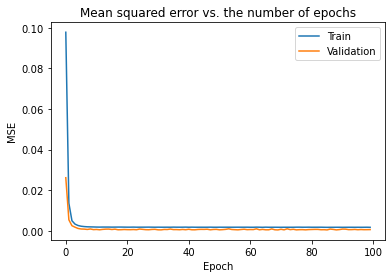

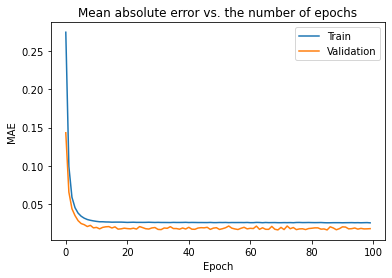

In [11]:
def visualising_data_MSE(hist, name):
#     MSE
    plt.title('Mean squared error vs. the number of epochs')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

def visualising_data_MAE(hist, name):
    plt.title('Mean absolute error vs. the number of epochs')
    plt.plot(hist.history['mean_absolute_error'], label='Train')
    plt.plot(hist.history['val_mean_absolute_error'], label='Validation')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()
    
# data up to the best epoch
# visualising_data_MSE(hypermodel_hist, '/Users/jackkelly/Desktop/Building_Model/Figures/hypermodel_results_MSE.svg')
# data for the full 100 epochs
visualising_data_MSE(history, '/Users/jackkelly/Desktop/Building_Model/Figures/full_epochs_results_MSE_FPGA.svg')
visualising_data_MAE(history, '/Users/jackkelly/Desktop/Building_Model/Figures/full_epochs_results_MAE_FPGA.svg')

In [12]:
# shows weights of the ANN
# print(hypermodel.weights)
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 196)               8232      
_________________________________________________________________
dropout (Dropout)            (None, 196)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                7880      
Total params: 16,112
Trainable params: 16,112
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compare to previous model
# model_drop01 = keras.models.load_model('/Users/jackkelly/Desktop/Building_Model/Tuned_40_channels_ANN_model_FPGA.h5')
# drop01_result = model_drop01.evaluate(X_test, Y_test, verbose=0)[1]
# print(f'MSE test with Dropout 0.1: {drop01_result}')
# print(f'MSE test with Dropout 0.2: {eval_result}')

In [14]:
# save the tuned model
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_40_channels_ANN_model_FPGA.h5')

In [97]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(hypermodel, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /var/folders/yp/nbwcv8453t3f3sx3xxwwycqm0000gn/T/tmplve3fos_.h5


# Low-magnitude Pruning

In [110]:
import tensorflow_model_optimization as tfmot

model = keras.models.load_model('/Users/jackkelly/Desktop/Building_Model/Tuned_40_channels_ANN_model_FPGA.h5')

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 100
validation_split = 0.2 # 20% of training set will be used for validation set. 

# num_images = train_images.shape[0] * (1 - validation_split)
# end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
# pruning_params = {
#       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,
#                                                                final_sparsity=0.80,
#                                                                begin_step=0,
#                                                                end_step=2000)
# }

model_for_pruning = prune_low_magnitude(model)

# `prune_low_magnitude` requires a recompile.
# model_for_pruning.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error', 'mean_absolute_error'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_dense (P (None, 196)               16270     
_________________________________________________________________
prune_low_magnitude_dropout  (None, 196)               1         
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 40)                15722     
Total params: 31,993
Trainable params: 16,112
Non-trainable params: 15,881
_________________________________________________________________


In [111]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X_scale, Y_scale,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks, verbose=0)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - ETA: 5:49 - loss: 0.0090 - mean_squared_error: 0.0084 - mean_absolute_error: 0.05 - ETA: 1:11 - loss: 0.0097 - mean_squared_error: 0.0091 - mean_absolute_error: 0.05 - ETA: 21s - loss: 0.0086 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0505 - ETA: 12s - loss: 0.0076 - mean_squared_error: 0.0070 - mean_absolute_error: 0.047 - ETA: 8s - loss: 0.0070 - mean_squared_error: 0.0064 - mean_absolute_error: 0.045 - ETA: 6s - loss: 0.0065 - mean_squared_error: 0.0059 - mean_absolute_error: 0.04 - ETA: 5s - loss: 0.0062 - mean_squared_error: 0.0055 - mean_absolute_error: 0.04 - ETA: 4s - loss: 0.0059 - mean_squared_error: 0.0053 - mean_absolute_error: 0.04 - ETA: 3s - loss: 0.0057 - mean_squared_error: 0.0051 - mean_absolute_error: 0.04 - ETA: 2s - loss: 0.0055 - mean_squared_error: 0.0049 - mean_absolute_error: 0.04 - ETA: 2s - loss: 0.0053 - mean_squared_error: 0.0047 - mean_absolu

8000/8000 [==============================] - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0027 - mean_squared_error: 0.0020 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0027 - mean_squared_error: 0.0020 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0020 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0019 -

8000/8000 [==============================] - ETA: 2s - loss: 0.0028 - mean_squared_error: 0.0021 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 -

Epoch 17/100
8000/8000 [==============================] - ETA: 2s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_er

8000/8000 [==============================] - ETA: 1s - loss: 0.0026 - mean_squared_error: 0.0020 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0021 - mean_squared_error: 0.0014 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 -

8000/8000 [==============================] - ETA: 2s - loss: 0.0019 - mean_squared_error: 0.0012 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 -

8000/8000 [==============================] - ETA: 2s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0019 - mean_squared_error: 0.0013 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0027 - mean_squared_error: 0.0020 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0029 - mean_squared_error: 0.0022 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

Epoch 48/100
8000/8000 [==============================] - ETA: 1s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_er

8000/8000 [==============================] - ETA: 1s - loss: 0.0017 - mean_squared_error: 0.0010 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0022 - mean_squared_error: 0.0015 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 -

8000/8000 [==============================] - ETA: 2s - loss: 0.0028 - mean_squared_error: 0.0021 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 4s - loss: 0.0022 - mean_squared_error: 0.0015 - mean_absolute_error: 0.02 - ETA: 2s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 2s - loss: 0.0030 - mean_squared_error: 0.0023 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0018 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0027 - mean_squared_error: 0.0020 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0016 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0018 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0028 - mean_squared_error: 0.0021 - mean_absolute_error: 0.03 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0023 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0026 - mean_squared_error: 0.0019 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

8000/8000 [==============================] - ETA: 1s - loss: 0.0027 - mean_squared_error: 0.0020 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0017 -

In [112]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data_testing.csv'
X_test, Y_test = processing_data(N_channels, file_path)
model_for_pruning_accuracy = model_for_pruning.evaluate(X_test, Y_test, verbose=0)[1]
print(f'Pruned model MSE: {model_for_pruning_accuracy}')
print(f'Initial model MSE: {eval_result}')

Pruned model MSE: 0.0005371348233893514
Initial model MSE: 0.000505145697388798


In [113]:
# %tensorboard --logdir={logdir}

In [114]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /var/folders/yp/nbwcv8453t3f3sx3xxwwycqm0000gn/T/tmp_68ena9n.h5


In [115]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [116]:
### One hidden layer vs Pruned model
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))

Size of gzipped baseline Keras model: 61486.00 bytes
Size of gzipped pruned Keras model: 39394.00 bytes


In [117]:
### Two hidden layer model
two_layer_model = keras.models.load_model('/Users/jackkelly/Desktop/Building_Model/Tuned_40_channels_ANN_model.h5')
_, two_layer_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(two_layer_model, two_layer_keras_file, include_optimizer=False)
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(two_layer_keras_file)))

Size of gzipped pruned Keras model: 91070.00 bytes


In [118]:
model_for_export.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 196)               8232      
_________________________________________________________________
dropout (Dropout)            (None, 196)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                7880      
Total params: 16,112
Trainable params: 16,112
Non-trainable params: 0
_________________________________________________________________
